In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import time
from sklearn.compose import ColumnTransformer

In [2]:
# Loading Dataset
data_path = 'https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true'
df = pd.read_csv(data_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             1199 non-null   object 
 1   Item                1199 non-null   object 
 2   Year                1199 non-null   int64  
 3   Yield (100 hg/ha)   1199 non-null   int64  
 4   Pesticides (Tons)   1199 non-null   float64
 5   Rainfall (mm)       1199 non-null   float64
 6   Fertilizer (kg/ha)  1199 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 65.7+ KB


In [4]:
df_processed = df.drop(['Item','Year'], axis=1)
df_processed

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [5]:
# Select features (X) and target variable (y)
features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)', 'Country']
target = 'Yield (100 hg/ha)'

X = df_processed[features]
y = df_processed[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [6]:
# Create transformers for numeric and categorical features
numeric_features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
categorical_features = ['Country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with scaling, one-hot encoding, and Ridge regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Define the hyperparameter grid
param_grid = {
    'ridge__alpha': [0.1, 1, 10, 100]
}

# Perform grid search
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, error_score = 'raise').fit(X_train, y_train)

# Print the best hyperparameters
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'ridge__alpha': 0.1}


In [7]:
# Access the best estimator from the search results
best_model = search.best_estimator_

# Training the RandomForestRegressor model using the best estimator
start_training_time = time.time()
best_model.fit(X_train, y_train)
end_training_time = time.time()
training_time = end_training_time - start_training_time

# Make predictions using the best estimator
start_prediction_time = time.time()
y_pred = best_model.predict(X_test)
end_prediction_time = time.time()
prediction_time = end_prediction_time - start_prediction_time

In [8]:
# Evaluate the model
r2 = r2_score(y_test, y_pred) # R^2
mae = mean_absolute_error(y_test, y_pred) # mean absolute error
mse = mean_squared_error(y_test, y_pred) # mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False) # root mean squared error
max_err = max_error(y_test, y_pred) # max error
mape = mean_absolute_percentage_error(y_test, y_pred) # mean absolute percentage error

print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Max Error: {max_err:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.5f} seconds")

R-squared (R2): 0.87
Mean Absolute Error (MAE): 6239.36
Mean Squared Error (MSE): 162007639.26
Root Mean Squared Error (RMSE): 12728.22
Max Error: 130682.38
Mean Absolute Percentage Error (MAPE): 0.15%
Training Time: 0.03 seconds
Prediction Time: 0.01223 seconds


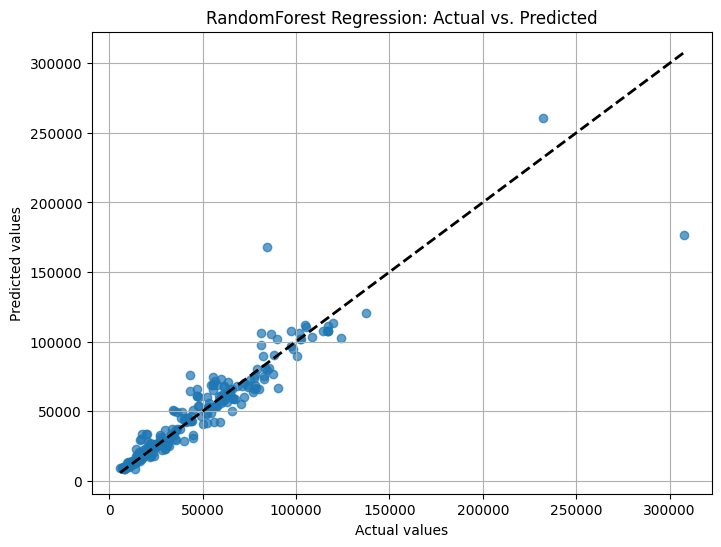

In [9]:
# Visualize predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('RandomForest Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()

In [10]:
# Assuming best_model is your Ridge regression model
ridge_model = best_model.named_steps['ridge']

# Get the original numeric feature names
numeric_feature_names = X_train.select_dtypes(include=['float64', 'int64']).columns

# Get the one-hot encoded feature names for categorical columns
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(X_train.select_dtypes(include=['object']).columns)

# Concatenate numeric and categorical feature names
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Create a DataFrame to store feature names and their coefficients
feature_coefficients_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': ridge_model.coef_})

# Sort features by coefficient magnitude
feature_coefficients_df = feature_coefficients_df.reindex(feature_coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Get the top 5 features based on coefficient magnitudes
top_features = feature_coefficients_df.head(5)

# Print the top 5 features
print("Top 5 Features:")
print(top_features)

Top 5 Features:
                Feature    Coefficient
54       Country_Israel  200584.139955
60       Country_Kuwait  124514.118403
27        Country_Chile   65111.590054
101  Country_Tajikistan   58378.182729
73      Country_Morocco  -56743.500534
